In [ ]:
import pandas as pd
from datasets import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import sys
import csv

# Increase the maximum field size
csv.field_size_limit(sys.maxsize)

# Load the dataset
# Use the 'python' engine for more robust parsing of potentially malformed lines
file_path = '/content/drive/MyDrive/PubMed Abstract Summarization Dataset/train.csv'
df = pd.read_csv(file_path, on_bad_lines='skip', engine='python')


# Optional cleanup
df = df.dropna(subset=["article", "abstract"])
df = df[df['article'].str.strip() != '']
df = df[df['abstract'].str.strip() != '']

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df[['article', 'abstract']])

In [ ]:
max(df['article'].apply(lambda x: len(x)))

825741

### Exploratory Data Analysis

In [ ]:
df.shape

(117108, 2)

In [ ]:
df.head()

,article,abstract
0,a recent systematic analysis showed that in 20...,background : the present study was carried out...
1,it occurs in more than 50% of patients and may...,backgroundanemia in patients with cancer who a...
2,"tardive dystonia ( td ) , a rarer side effect ...",tardive dystonia ( td ) is a serious side effe...
3,"lepidoptera include agricultural pests that , ...",many lepidopteran insects are agricultural pes...
4,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough ...


(np.float64(-0.5), np.float64(1199.5), np.float64(1199.5), np.float64(-0.5))

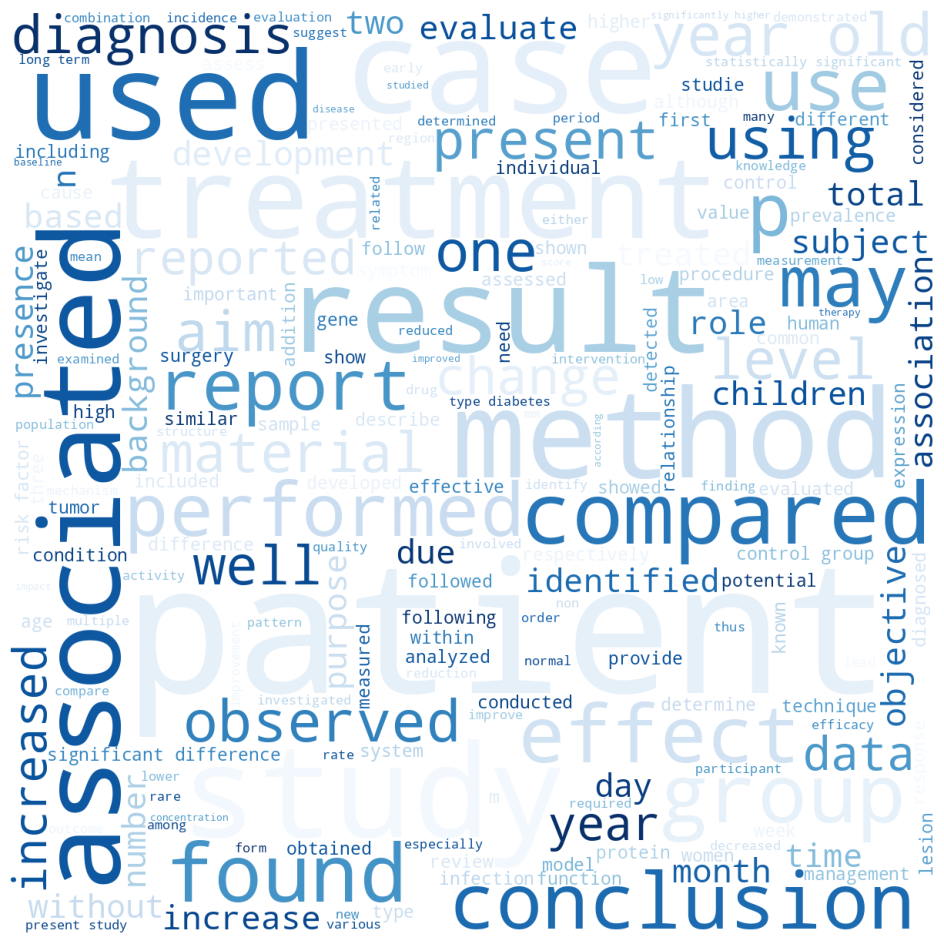

In [ ]:
from matplotlib.pyplot import subplots
from matplotlib.pyplot import axis
from matplotlib.pyplot import imshow
from wordcloud import WordCloud
from wordcloud import STOPWORDS

FRACTION = 1.0
subplots(figsize=(12, 12))
text = ' '.join(df.sample(frac=FRACTION, random_state=42)['abstract'].values.tolist())
imshow(X=WordCloud(random_state=42, height=1200, width=1200, stopwords=STOPWORDS, background_color='white', colormap='Blues').generate(text=text), )
axis('off')

### Preprocessing

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Reduced max_input_length and max_target_length
max_input_length = 1024
max_target_length = 1024

def preprocess_function(examples):
    inputs = tokenizer(
        examples["article"], max_length=max_input_length, truncation=True, padding="max_length"
    )
    targets = tokenizer(
        examples["abstract"], max_length=max_target_length, truncation=True, padding="max_length"
    )
    inputs["labels"] = targets["input_ids"]
    return inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=["article", "abstract"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/117108 [00:00<?, ? examples/s]

### Load and Train the model

In [ ]:
from transformers import AutoModelForSeq2SeqLM, TrainingArguments, Trainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

training_args = TrainingArguments(
    output_dir="./summarizer_pubmed_mednlp",
    eval_strategy="no",
    learning_rate=3e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=1,
    fp16=True,  # if using GPU with float16 support
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
)

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

/tmp/ipython-input-17-2806750369.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: parthasai28 (parthasai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,8.038800
20,8.779300
30,7.573100
40,5.361300
50,3.772400
60,3.094800
70,2.433200
80,2.587200
90,2.459400
100,2.428500


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3685: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Step,Training Loss
10,8.038800
20,8.779300
30,7.573100
40,5.361300
50,3.772400
60,3.094800
70,2.433200
80,2.587200
90,2.459400
100,2.428500


TrainOutput(global_step=73195, training_loss=0.472275982480271, metrics={'train_runtime': 45721.6984, 'train_samples_per_second': 12.807, 'train_steps_per_second': 1.601, 'total_flos': 1.2689264287206605e+18, 'train_loss': 0.472275982480271, 'epoch': 5.0})

In [ ]:
model_save_path = "/content/drive/MyDrive/models/bart_pubmed_finetuned_latest1"
model.save_pretrained(model_save_path,safe_serialization=True)
tokenizer.save_pretrained(model_save_path)
model.config.save_pretrained(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/models/bart_pubmed_finetuned_latest1


### Prediction

In [ ]:
model.eval()

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        

### Evaluation with ROUGE Scores

In [ ]:
!pip install rouge_score
!pip install evaluate
import evaluate

rouge = evaluate.load("rouge")

preds = []
refs = []
for i in range(100):  # evaluate on first 100 samples
    input_text = test_df['article'].iloc[i]
    reference = test_df['abstract'].iloc[i]
    pred = summarize(input_text, model, tokenizer)
    preds.append(pred)
    refs.append(reference)

results = rouge.compute(predictions=preds, references=refs)
print(results)

{'rouge1': np.float64(0.42742831763692285), 'rouge2': np.float64(0.16968035361441508), 'rougeL': np.float64(0.24755766509159863), 'rougeLsum': np.float64(0.37574763498693686)}


In [ ]:
#Loading the saved model and testing
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import pandas as pd

model_path = "/content/drive/MyDrive/models/bart_pubmed_finetuned_latest1"
loaded_model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
loaded_model.eval()

# Load and clean test data
test_df = pd.read_csv("/content/drive/MyDrive/PubMed Abstract Summarization Dataset/test.csv")  # Adjust path
test_df = test_df.dropna(subset=["article", "abstract"])
test_df = test_df[test_df['article'].str.strip() != '']
test_df = test_df[test_df['abstract'].str.strip() != '']

import torch


def summarize(text, loaded_model, tokenizer, max_input_length=1024, max_output_length=1024):
    # Tokenize to tensors (includes attention_mask)
    enc = tokenizer(
        text,
        return_tensors="pt",
        max_length=max_input_length,
        truncation=True
    )

    # Send tensors to the same device as the model
    device = next(loaded_model.parameters()).device
    enc = {k: v.to(device) for k, v in enc.items()}

    # Generate (pass the full batch: input_ids + attention_mask)
    summary_ids = loaded_model.generate(
        **enc,
        max_length=max_output_length,
        min_length=30,
        num_beams=6,
        length_penalty=2.5,
        early_stopping=True,
        # Optional guardrails if repetition occurs:
        no_repeat_ngram_size=3,
        repetition_penalty=1.1,
    )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Test on a sample
sample_article = test_df['article'].iloc[10]
print("Original:\n", sample_article[:1000])
print("\nPredicted Summary:\n", summarize(sample_article, loaded_model, tokenizer))


/usr/local/lib/python3.11/dist-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


Original:
 male macroprolactinomas ( mprl ) are usually revealed by headaches , visual troubles and gonadal insufficiency . 
 suppurative meningitis ( sm ) , a life - threatening condition , is scarcely observed in subjects with macro tumors secreting prolactin ( prl ) and in other pituitary tumors ( pt ) . 
 however , in some very rare cases it can be a primary presentation or appear after radiotherapy or medical treatment used for tumors destroying the sellar floor and/or the skull base . 
 this destruction leads to cerebral spinal fluid ( csf ) leak , which can act as an entry portal for organisms predisposing to meningitis . 
 our aim was to analyze sm frequency among male mprl deemed to be very invasive tumors , to report our cases and analyze the circumstances under which the dangerous neurological complication appeared . 
 in this retrospective study , we analyzed 82 subjects with mprl to look for symptoms , clinical signs and biological proof of sm . 
 , we took into account me

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1739: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(



Predicted Summary:
 suppurative meningitis ( sm ) , a life - threatening condition , is scarcely observed in subjects with macro tumors secreting prolactin ( prl ) and in other pituitary tumors ( pt ) . 
 however , in some very rare cases it can be a primary presentation or appear after radiotherapy or medical treatment used for tumors destroying the sellar floor and/or the skull base . our aim was to analyze sm frequency among male macroprolactinomas ( mprl ) deemed to be very invasive tumors , to report our cases and analyze the circumstances under which the dangerous neurological complication appeared . in this retrospective study 
 , we analyzed 82 subjects with mprls to look for symptoms , clinical signs and biological proof of sm . among them , we took into account medical history , clinical examination , routine exploration , cerebrospinal fluid ( csf ) analysis and hormonal assessment . of the 82 subjects , 
 4 patients were diagnosed with sm : three were first hospitalized in